# Set-up

## Installing libraries and libcudnn8

In [1]:
## only with GPU
import sys
sys.path.insert(0,'/kaggle/input/mi-eeg-classmeth/')
#FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!apt-get install --allow-change-held-packages libcudnn8=8.1.1.33-1+cuda11.2 -y
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models.git
!pip install mne
!pip install scikeras[tensorflow]
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
#!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
#!dir

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 91 not upgraded.
Need to get 421 MB of archives.
After this operation, 2621 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.1.33-1+cuda11.2 [421 MB]
Fetched 421 MB in 6s (68.0 MB/s)                                               
(Reading database ... 108827 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.0) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 108805 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.1.33-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.1.3

## Import libraries

In [2]:
!pip install tensorflow-probability==0.18.* --quiet
!pip install tensorflow==2.10.* --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires absl-py<2.0.0,>=0.9, but you have absl-py 2.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires absl-py<2.0.0,>=0.9, but you have absl-py 2.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.10.1 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.10.1 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.34.0 which is incompatible.


In [3]:
# gcpds datasets
from gcpds.databases import GIGA_MI_ME
from gcpds.databases.BCI_Competition_IV import Dataset_2a
import gcpds.databases as loaddb

# freq filter 
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr

# general
import numpy as np
from scipy.signal import resample
import pickle
import warnings
import mne
from time import time
warnings.filterwarnings('ignore')

# tensorlfow 
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, AveragePooling2D, BatchNormalization, Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import L1L2

# scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score

2023-12-01 19:32:18.092567: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define functions

In [4]:
tf.__version__

'2.10.1'

In [5]:
def kappa(y_true, y_pred):
    return cohen_kappa_score(np.argmax(y_true, axis = 1),np.argmax(y_pred, axis = 1))

## GIGA Science dataset

In [6]:
def load_GIGA(db: GIGA_MI_ME,
              sbj: int,
              fs: float, 
              f_bank: np.ndarray, 
              vwt: np.ndarray, 
              new_fs: float) -> np.ndarray:

    eeg_ch_names = ['Fp1','Fpz','Fp2',
              'AF7','AF3','AFz','AF4','AF8',
              'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
              'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
              'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
              'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
              'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
              'PO7','PO3','POz','PO4','PO8',
              'O1','Oz','O2',
              'Iz']

    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:,index_eeg_chs,:] #spatial rearrangement
    X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)
    return X, y

## BCI2a dataset

In [7]:
def load_BCICIV2a(db: Dataset_2a,
               sbj: int,
               fs: float, 
               f_bank: np.ndarray, 
               vwt: np.ndarray, 
               new_fs: float) -> np.ndarray:

    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)
    # training 
    db.load_subject(sbj, mode = 'training')
    X_tr, y_tr = db.get_data() #Load all classes, all channels {EEG, EOG}, reject bad trials
    X_tr = X_tr[:,:-3,:] # pick EEG channels
    X_tr = X_tr*1e6 #uV
    X_tr = np.squeeze(tf_repr.transform(X_tr))
    # testing
    db.load_subject(sbj, mode = 'evaluation')
    X_ts, y_ts = db.get_data() #Load all classes, all channels {EEG, EOG}, reject bad trials
    X_ts = X_ts[:,:-3,:] # pick EEG channels
    X_ts = X_ts*1e6 #uV
    X_ts = np.squeeze(tf_repr.transform(X_ts))
    # merge both training and evaluation sets  
    X = np.concatenate([X_tr, X_ts], axis = 0)
    y = np.concatenate([y_tr, y_ts], axis = 0)    
    # Resampling
    if new_fs == fs:
        print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)
    return X, y

## Define the model (Gaussian functional conectivity network)

In [8]:
def renyis_entropy_2(A):
    """
    Renyis entropy with alpha = 2
    Input
    -----
    A Tensor (batch_dim, filters, n_chans, n_chans)
    Output
    ------
    H Tensor (batch_dim, n_freq_bands)
    """
    tr = tf.linalg.trace(A)
    A = A/tf.expand_dims(tf.expand_dims(tr,axis=-1),axis=-1)
    H = -tf.math.log(tf.linalg.trace(tf.linalg.matmul(A ,A)))
    return H

In [9]:
class GFC(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super().__init__(**kwargs)
        

    def build(self, batch_input_shape):
        self.gammad = self.add_weight(name = 'gammad',
                                shape = (),
                                initializer = 'zeros',
                                trainable = True)
        super().build(batch_input_shape)

    def call(self, X): 
        X = tf.transpose(X, perm  = (0, 3, 1, 2)) #(N, F, C, T)
        R = tf.reduce_sum(tf.math.multiply(X, X), axis = -1, keepdims = True) #(N, F, C, 1)
        D  = R - 2*tf.matmul(X, X, transpose_b = True) + tf.transpose(R, perm = (0, 1, 3, 2)) #(N, F, C, C)

        ones = tf.ones_like(D[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(D, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)
        sigma = tfp.stats.percentile(tf.math.sqrt(triu), 50, axis = 2, keepdims = True) #(N, F, 1, 1)

        A = tf.math.exp(-1/(2*tf.pow(10., self.gammad)*tf.math.square(sigma))*D) #(N, F, C, C)
        A.set_shape(D.shape)
        self.add_loss(-self.alpha*tf.reduce_mean(renyis_entropy_2(A)))
        #self.add_loss(-self.alpha*tf.reduce_sum(renyis_entropy_2(A))) # reduce sum
#         self.add_loss(self.alpha*renyis_entropy_2(A))
#         self.add_loss(self.alpha*renyis_entropy_2(A))
#         self.add_loss(self.alpha*renyis_entropy_2(A))
        return A

    def compute_output_shape(self, batch_input_shape):
        N, C, T, F = batch_input_shape.as_list()
        return tf.TensorShape([N, F, C, C])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}


class get_triu(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        super().build(batch_input_shape)

    def call(self, X): 
        N, F, C, C = X.shape
        ones = tf.ones_like(X[0,0,...]) #(C, C)
        mask_a = tf.linalg.band_part(ones, 0, -1) #Upper triangular matrix of 0s and 1s (C, C)
        mask_b = tf.linalg.band_part(ones, 0, 0)  #Diagonal matrix of 0s and 1s (C, C)
        mask = tf.cast(mask_a - mask_b, dtype=tf.bool) #Make a bool mask (C, C)
        triu = tf.expand_dims(tf.boolean_mask(X, mask, axis = 2), axis = -1) #(N, F, C*(C-1)/2, 1)

        triu.set_shape([N,F,int(C*(C-1)/2),1])
        return triu

    def compute_output_shape(self, batch_input_shape):
        N, F, C, C = batch_input_shape.as_list()
        return tf.TensorShape([N, F, int(C*(C-1)/2),1])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
    
def GFC_reg_renyi(nb_classes: int,
          Chans: int,
          Samples: int,
          l1: int = 0, 
          l2: int = 0, 
          dropoutRate: float = 0.5,
          filters: int = 1, 
          maxnorm: float = 2.0,
          maxnorm_last_layer: float = 0.5,
          kernel_time_1: int = 20,
          strid_filter_time_1: int = 1,
          bias_spatial: bool = False,
          alpha: float = 1) -> Model:


    input_main   = Input((Chans, Samples, 1),name='Input')                    
    
    block        = Conv2D(filters,(1,kernel_time_1),strides=(1,strid_filter_time_1),
                            use_bias=bias_spatial,
                            kernel_constraint = max_norm(maxnorm, axis=(0,1,2))
                            )(input_main)
    
    block        = BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = Activation('elu')(block)      
    
    block        = GFC(alpha=alpha)(block)

    block        = get_triu()(block)

    block        = AveragePooling2D(pool_size=(block.shape[1],1),strides=(1,1))(block)
    
    block        = BatchNormalization(epsilon=1e-05, momentum=0.1)(block)

    block        = Activation('elu')(block) 
    
    block        = Flatten()(block)    

    block        = Dropout(dropoutRate)(block) 

    block        = Dense(nb_classes, kernel_regularizer=L1L2(l1=l1,l2=l2),name='logits',
                              kernel_constraint = max_norm(maxnorm_last_layer)
                              )(block)

    softmax      = Activation('softmax',name='output')(block)
    
    return Model(inputs=input_main, outputs=softmax)

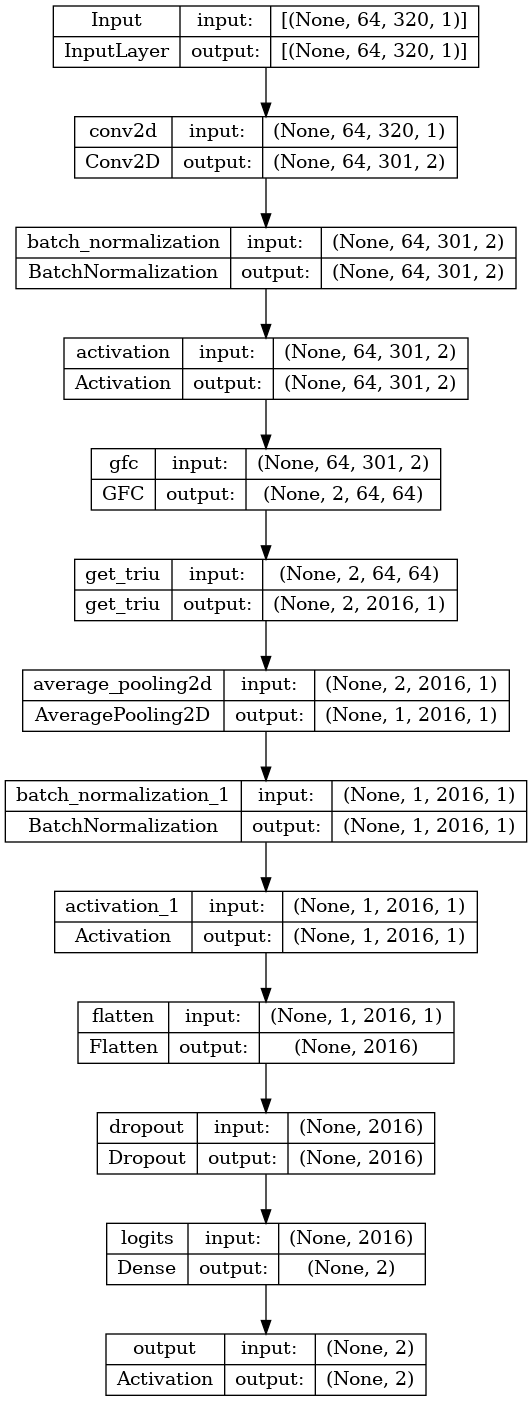

In [10]:
model= GFC_reg_renyi(nb_classes=2, 
        filters=2,
        Chans =64, 
        Samples = 320)
#model.summary()
tf.keras.utils.plot_model(model,   show_shapes=True)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 320, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 301, 2)        40        
                                                                 
 batch_normalization (BatchN  (None, 64, 301, 2)       8         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 301, 2)        0         
                                                                 
 gfc (GFC)                   (None, 2, 64, 64)         1         
                                                                 
 get_triu (get_triu)         (None, 2, 2016, 1)        0         
                                                             

# Experiment

## Experiment configuration 

In [12]:
seed=23
folds=5
epochs_train = 500 #500
data_set='GIGA_MI_ME'## BCICIV2a # GIGA_MI_ME

save_folder = 'GFC_renyi_reg_v2_128Hz'
Experiment=f'{data_set}__{folds}_fold'

model_name= f'{save_folder}{epochs_train}_epoch'


In [13]:
PATH=f'./{save_folder}/'
!mkdir '{PATH}'

## Run experiment

In [14]:
tf.random.set_seed(seed)
# PATH to prevoius results GFCnet
PATH_pre_results = '../input/results-giga-gfc-eeg-net/GIGA-20221221T182045Z-001/'

if data_set=='GIGA_MI_ME':
    subjects = np.arange(52)+1
    subjects = np.delete(subjects,[28,33])
    db = GIGA_MI_ME('../input/giga-science-gcpds/GIGA_MI_ME/') # update path
    num_class = 2
    load_args = dict(db = db,
                fs = db.metadata['sampling_rate'],
                f_bank = np.asarray([[4., 40.]]),
                vwt = np.asarray([[2.5, 5]]),
                new_fs = 128.0)    
    PATH_pre_results=PATH_pre_results+'GIGA/'
elif data_set=='BCICIV2a':
    subjects = np.arange(9)+1
    db = Dataset_2a('../input/bciiv2a-gcpds/BCI_CIV_2a/') # update path
    num_class = 4
    load_args = dict(db = db,
                fs = db.metadata['sampling_rate'],
                f_bank = np.asarray([[4., 40.]]),
                vwt = np.asarray([[2.5, 6]]),
                new_fs = 128.0)
    PATH_pre_results=PATH_pre_results+'BCI2a/'
else:
    print('Select a valid dataset')            

folder_results = PATH_pre_results+'GFC_triu_avg_128Hz/'
for sbj in [4]:#subjects[:3]:#subjects:
    t=time()
    
    print('loading prevoius best params')
    scores_path=f'{folder_results}Results_{data_set}__5_fold_GFC_triu_avg_128Hz500_epoch_sujeto_{sbj}_{data_set}_4_40.p'
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)
    Nfilters = cv['params'][cv['best_index_']]['filters']
    kernel_time = cv['params'][cv['best_index_']]['kernel_time_1']  
    print(f'loading sbj: {sbj} data')
    load_args['sbj'] = sbj
    if data_set=='GIGA_MI_ME':
        X_train, y_train = load_GIGA(**load_args)
    elif data_set=='BCICIV2a':
        X_train, y_train = load_BCICIV2a(**load_args)
    X_train = X_train[..., np.newaxis]
    Y_train = tf.keras.utils.to_categorical(y_train,num_classes=num_class)
    # build model
    clf = KerasClassifier(
        GFC_reg_renyi,
        random_state=seed,
        
        #model hyperparameters
        nb_classes=num_class, 
        Chans = X_train.shape[1], 
        Samples = X_train.shape[2],
        dropoutRate=0.5,
        l1 = 0, l2 = 0,
        alpha=1.0,
        filters=2, maxnorm=2.0,maxnorm_last_layer=0.5,
        kernel_time_1=25,strid_filter_time_1= 1,
        bias_spatial = False,

        #model config
        verbose=0,
        batch_size=500, #full batch        
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer="adam",
        optimizer_learning__rate=0.1,
        metrics = ['accuracy'],
        epochs = epochs_train
    )
    # search params
    param_grid =  {
                'filters':[Nfilters], #2,4
                'kernel_time_1':[kernel_time], #25,50
                'alpha':[0,0.2,0.5,0.7,1,5,10]
                }
    
    #Gridsearch
    scoring = {"AUC": 'roc_auc', "Accuracy": make_scorer(accuracy_score),'Kappa':make_scorer(kappa)}
    
    cv = GridSearchCV(clf,param_grid,cv=StratifiedShuffleSplit(n_splits = folds, test_size = 0.2, random_state = seed),
                         verbose=0,n_jobs=1,
                         scoring=scoring,
                         refit="Accuracy",
                            )
    # frind best params with gridsearch
    cv.fit(X_train,Y_train)
    # best score
    print('Subject',sbj,'Accuracy',cv.best_score_,'elapsed time',time()-t)
    print('---------')
    
    cv.cv_results_['best_index_']=cv.best_index_
    
    #########
    cv.best_estimator_.model_.save_weights(f'{PATH}Model_{Experiment}_{model_name}_sujeto_{sbj}_'+data_set+'_4_40_weights.h5')
    with open(PATH+'Results_'+Experiment+'_'+model_name+'_sujeto_'+str(sbj)+'_'+data_set+'_4_40.p','wb') as f:
        pickle.dump(cv.cv_results_,f)     

loading prevoius best params
loading sbj data
Resampling from 512.000000 to 128.000000 Hz.
Subject 4 Accuracy 0.9 elapsed time 1746.3408274650574
---------


In [ ]:
!rm -r ./MI_EEG_ClassMeth
!rm -r ./__MACOSX
!rm ./MI_EEG_ClassMeth.zip